In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from helpers import *
pd.set_option('mode.chained_assignment', None)

In [2]:
# Retrieve the latest DataFrame models
plane_df, cylinder_df, point_df = get_latest_models()

# Extract sleeve data
sleeve_planes, sleeve_cyl, sleeve_points = parts_only_set(plane_df, cylinder_df, point_df, ['INSS', 'GASS', 'SESL'])

## Datum Features

Number of parts:  65
0.938 % acceptance rate


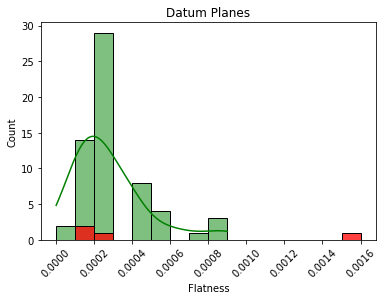

In [5]:
# Spit planes by feature type
datumA, shoulders, midplanes = plane_split(sleeve_planes)

# Split by acceptance decision
apprA = drop_rejections(datumA)
rejA = rejections_only(datumA)

# Print high-level stat
print('Number of parts: ', len(datumA.index))
print(round((len(datumA.index) - len(rejA.index)) / len(datumA.index), 3), '% acceptance rate')

# Plot flatness
sns.histplot(apprA.flatness, kde=True, color='green', binwidth=.0001)
sns.histplot(rejA.flatness, color='red', binwidth=.0001)
plt.xticks(rotation=45)
plt.title('Datum Planes')
plt.xlabel('Flatness')
plt.show()

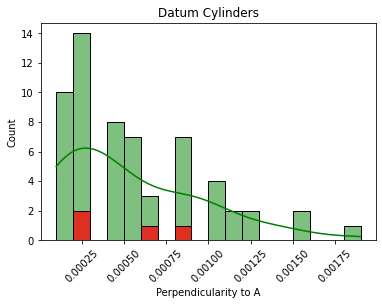

In [6]:
# Calculate egg_rate and deviation features, then split cylinders by feature type
sleeve_cyl['egg_rate'] = sleeve_cyl.cylindricity * 2 / sleeve_cyl.diameter_meas
sleeve_cyl['dia_dev'] = sleeve_cyl.diameter_meas - sleeve_cyl.diameter_nom
datumB, datumC, radials, holes = cylinder_split(sleeve_cyl)

# Calculate wall_thickness and save in datumB
for index, row in sleeve_cyl.iterrows():
    df = sleeve_cyl[sleeve_cyl.inspection_id == row.inspection_id]
    max_dia = df.diameter_meas.max()
    bore_dia = df[df.feature == 'datum cylinder B'].diameter_meas.values[0]
    wall_thickness = max_dia - bore_dia
    datumB.loc[datumB.inspection_id == row.inspection_id, 'wall_thickness'] = wall_thickness

# Spit datumB by acceptance decision
apprB = drop_rejections(datumB)
apprB = apprB[apprB.inspection_id != '133275-INSS-MFG-B_QC1.csv']

rejB = rejections_only(datumB)

# Plot perpendicularity to A
sns.histplot(apprB.perpendicular_a, kde=True, color='green', binwidth=.0001)
sns.histplot(rejB.perpendicular_a, color='red', binwidth=.0001)
plt.xticks(rotation=45)
plt.title('Datum Cylinders')
plt.xlabel('Perpendicularity to A')
plt.show()

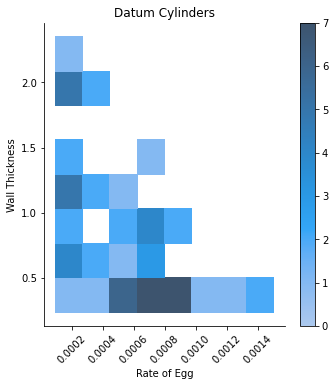

0.9384615384615385 % of cylinders within tolerance


In [14]:
# Plot egg_rate VS wall_thickness
sns.displot(x='egg_rate', y='wall_thickness', data=datumB, cbar=True)
plt.xticks(rotation=45)
plt.title('Datum Cylinders')
plt.xlabel('Rate of Egg')
plt.ylabel('Wall Thickness')
plt.show()


less_than_one = len(datumB[datumB.egg_rate <= .0010].index)
total = len(datumB.index)
print(less_than_one / total, '% of cylinders within tolerance')

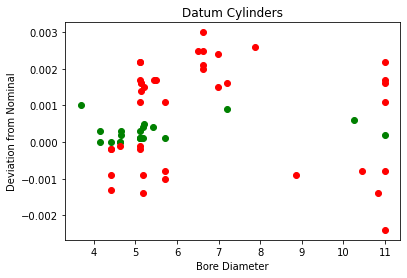

0.3333333333333333 % of approved sleeves within drawing tolerance


In [23]:
# Split approved parts by pass/fail
inTol = apprB[(apprB.dia_dev >= .0000) & (apprB.dia_dev <= .0010)]
outTol = apprB[(apprB.dia_dev < .0000) | (apprB.dia_dev > .0010)]

# Plot bore diameter deviations
plt.scatter(x=inTol.diameter_meas.tolist(), y=inTol.dia_dev.tolist(), color='green')
plt.scatter(x=outTol.diameter_meas.tolist(), y=outTol.dia_dev.tolist(), color='red')
plt.title('Datum Cylinders')
plt.xlabel('Bore Diameter')
plt.ylabel('Deviation from Nominal')
plt.show()

print(len(inTol.index) / len(apprB.index), '% of approved sleeves within drawing tolerance')

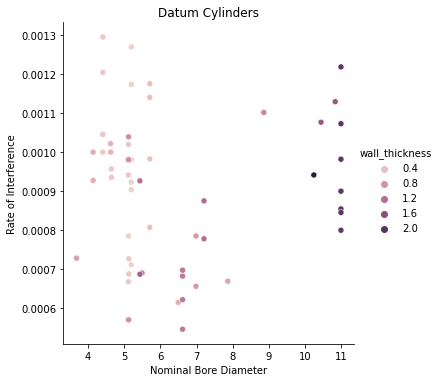

,perpendicular_a,total_runout_ab,position,cylindricity,diameter_nom,diameter_meas,length_nom,length_per,egg_rate,dia_dev,wall_thickness,intf_rate
count,60.000000,0.0,0.0,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.000552,NaN,NaN,0.001500,6.344515,6.345128,2.859530,0.939822,0.000535,0.000613,0.802988,0.000900
std,0.000425,NaN,NaN,0.000796,2.241370,2.241384,2.321963,0.040691,0.000337,0.001209,0.584603,0.000190
min,0.000100,NaN,NaN,0.000200,3.682000,3.683000,0.291900,0.803274,0.000091,-0.002400,0.236800,0.000546
25%,0.000200,NaN,NaN,0.000975,5.117000,5.117250,1.152850,0.921749,0.000218,-0.000100,0.320550,0.000723
50%,0.000400,NaN,NaN,0.001500,5.196000,5.196450,2.450600,0.950692,0.000542,0.000350,0.553650,0.000931
75%,0.000825,NaN,NaN,0.001900,6.985000,6.986725,3.678625,0.967062,0.000742,0.001600,1.092350,0.001020
max,0.001900,NaN,NaN,0.003900,10.995000,10.997200,9.015000,1.004342,0.001501,0.003000,2.351800,0.001295


In [25]:
# Plot the rate of interference relative to nominal bore diameter
Bpos = apprB[apprB.dia_dev >= .0000]
Bneg = apprB[apprB.dia_dev < .0000]

Bpos['intf_rate'] = (Bpos.diameter_nom * .0010 - Bpos.dia_dev) / Bpos.diameter_nom
Bneg['intf_rate'] = (Bneg.diameter_nom * .0010 + -1 * Bneg.dia_dev) / Bneg.diameter_nom

Btotal = Bpos.append(Bneg)
sns.relplot(x='diameter_nom', y='intf_rate', data=Btotal, hue='wall_thickness')
plt.title('Datum Cylinders')
plt.xlabel('Nominal Bore Diameter')
plt.ylabel('Rate of Interference')
plt.show()

Btotal.describe()

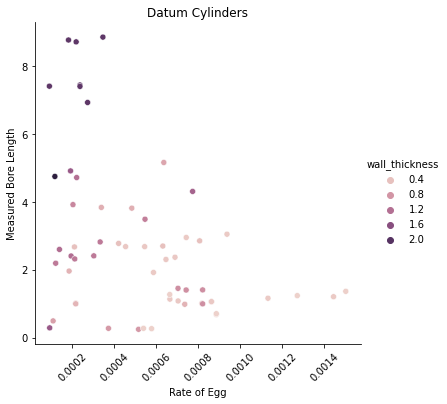

In [62]:
Btotal['length_meas'] = Btotal['length_nom'] * Btotal['length_per']
sns.relplot(x='egg_rate', y='length_meas', data=Btotal, hue='wall_thickness')
plt.title('Datum Cylinders')
plt.xlabel('Rate of Egg')
plt.ylabel('Measured Bore Length')
plt.xticks(rotation=45)
plt.show()

## Non-datum Features

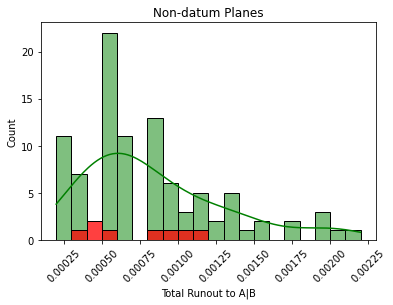

In [10]:
# Plot total runout with respect to datums A & B
appr_planes = drop_rejections(sleeve_planes)
rej_planes = rejections_only(sleeve_planes)

sns.histplot(appr_planes.total_runout_ab, kde=True, color='green', binwidth=.0001)
sns.histplot(rej_planes.total_runout_ab, color='red', binwidth=.0001)
plt.xticks(rotation=45)
plt.title('Non-datum Planes')
plt.xlabel('Total Runout to A|B')
plt.show()

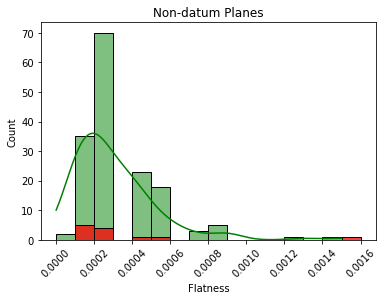

In [11]:
sns.histplot(appr_planes.flatness, kde=True, color='green', binwidth=.0001)
sns.histplot(rej_planes.flatness, color='red', binwidth=.0001)
plt.xticks(rotation=45)
plt.title('Non-datum Planes')
plt.xlabel('Flatness')
plt.show()

In [27]:
appr_radials = drop_rejections(radials)
rej_radials = rejections_only(radials)
appr_radials.describe()

,perpendicular_a,total_runout_ab,position,cylindricity,diameter_nom,diameter_meas,length_nom,length_per,egg_rate,dia_dev
count,0.0,124.000000,0.0,119.000000,127.000000,127.000000,120.000000,120.000000,119.000000,127.000000
mean,NaN,0.002664,NaN,0.001434,7.949466,7.949947,1.942255,0.922581,0.000434,0.000481
std,NaN,0.002160,NaN,0.000793,3.030746,3.029484,1.634650,0.108209,0.000325,0.009518
min,NaN,0.000600,NaN,0.000300,3.750000,3.750900,0.078100,0.565217,0.000072,-0.013000
25%,NaN,0.001400,NaN,0.000800,5.420800,5.437000,0.712250,0.880787,0.000173,-0.002100
50%,NaN,0.002200,NaN,0.001200,6.518000,6.517600,1.226500,0.948832,0.000293,-0.000300
75%,NaN,0.002900,NaN,0.002050,11.035000,11.035000,3.250000,0.977041,0.000625,0.000950
max,NaN,0.011700,NaN,0.003600,12.938000,12.939200,6.187500,1.489031,0.001404,0.040100


In [28]:
rej_radials.describe()

,perpendicular_a,total_runout_ab,position,cylindricity,diameter_nom,diameter_meas,length_nom,length_per,egg_rate,dia_dev
count,0.0,7.000000,0.0,7.000000,8.000000,8.000000,5.000000,5.000000,7.000000,8.000000
mean,NaN,0.002700,NaN,0.001586,7.952000,7.952050,2.083960,0.912519,0.000398,0.000050
std,NaN,0.001479,NaN,0.000615,0.851194,0.850861,2.151088,0.120714,0.000130,0.001568
min,NaN,0.001100,NaN,0.000900,6.097000,6.096000,0.375000,0.708800,0.000232,-0.001900
25%,NaN,0.001500,NaN,0.001100,7.688000,7.689950,0.718000,0.907545,0.000302,-0.000850
50%,NaN,0.002700,NaN,0.001400,8.306000,8.306050,0.892000,0.954889,0.000394,-0.000350
75%,NaN,0.003650,NaN,0.002100,8.457500,8.456850,2.952800,0.971861,0.000495,0.000550
max,NaN,0.004800,NaN,0.002400,8.709000,8.707100,5.482000,1.019499,0.000564,0.003000


In [78]:
radials_drop_errors = appr_radials[appr_radials.total_runout_ab < .005]
radials_drop_errors.describe()

,perpendicular_a,total_runout_ab,position,cylindricity,diameter_nom,diameter_meas,length_nom,length_per,egg_rate,dia_dev
count,0.0,116.000000,0.0,111.000000,116.000000,116.000000,109.000000,109.000000,111.000000,116.000000
mean,NaN,0.002185,NaN,0.001422,7.754671,7.755250,1.876728,0.917067,0.000433,0.000579
std,NaN,0.001014,NaN,0.000798,2.939298,2.938093,1.590098,0.110502,0.000322,0.009927
min,NaN,0.000600,NaN,0.000300,3.750000,3.750900,0.109400,0.565217,0.000072,-0.013000
25%,NaN,0.001375,NaN,0.000800,5.428700,5.437200,0.688700,0.864770,0.000178,-0.002125
50%,NaN,0.002100,NaN,0.001200,6.344500,6.345400,1.195000,0.943111,0.000293,-0.000400
75%,NaN,0.002800,NaN,0.001950,10.843750,10.842425,3.157700,0.973914,0.000625,0.000925
max,NaN,0.004800,NaN,0.003600,12.938000,12.939200,6.187500,1.489031,0.001404,0.040100


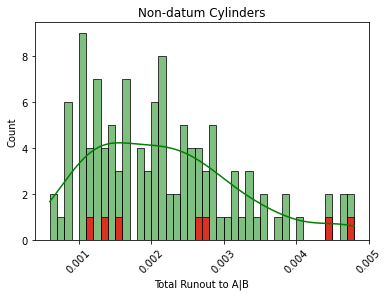

In [93]:
sns.histplot(radials_drop_errors.total_runout_ab, kde=True, color='green', binwidth=.0001)
sns.histplot(rej_radials.total_runout_ab, color='red', binwidth=.0001)
plt.xticks(rotation=45)
plt.title('Non-datum Cylinders')
plt.xlabel('Total Runout to A|B')
plt.show()

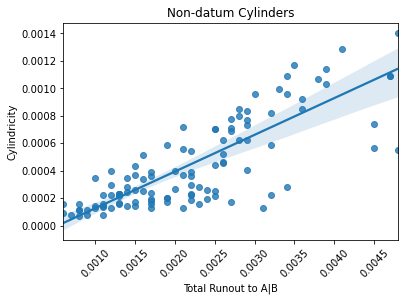

In [103]:
sns.regplot(x='total_runout_ab', y='egg_rate', data=radials_drop_errors, robust=True)
plt.xticks(rotation=45)
plt.title('Non-datum Cylinders')
plt.xlabel('Total Runout to A|B')
plt.ylabel('Cylindricity')
plt.show()

In [101]:
radials_inTol = len(radials_drop_errors[radials_drop_errors.total_runout_ab <= .0030].index)
print(radials_inTol / len(radials_drop_errors.index), '% of accepted parts within tolerance')

0.8189655172413793 % of accepted parts within tolerance


<AxesSubplot:ylabel='Frequency'>

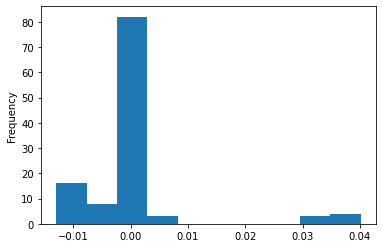

In [104]:
radials_drop_errors.dia_dev.plot(kind='hist')

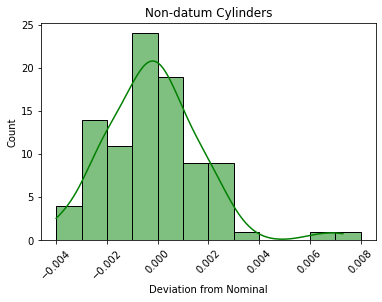

In [122]:
radials_drop_false_devs =  radials_drop_errors[(radials_drop_errors.dia_dev < .02) & (radials_drop_errors.dia_dev > -.005)]
sns.histplot(radials_drop_false_devs.dia_dev, kde=True, color='green', binwidth=.001)
plt.xticks(rotation=45)
plt.title('Non-datum Cylinders')
plt.xlabel('Deviation from Nominal')
plt.show()

In [123]:
radials_drop_false_devs.describe()

,perpendicular_a,total_runout_ab,position,cylindricity,diameter_nom,diameter_meas,length_nom,length_per,egg_rate,dia_dev
count,0.0,93.000000,0.0,91.000000,93.00000,93.000000,91.000000,91.000000,91.000000,93.000000
mean,NaN,0.002052,NaN,0.001313,8.30100,8.300848,1.923363,0.919030,0.000374,-0.000152
std,NaN,0.001033,NaN,0.000742,2.97866,2.978397,1.678520,0.116378,0.000293,0.001888
min,NaN,0.000600,NaN,0.000300,3.75000,3.750900,0.109400,0.565217,0.000072,-0.004000
25%,NaN,0.001300,NaN,0.000800,5.97900,5.978700,0.673550,0.861313,0.000167,-0.001300
50%,NaN,0.001900,NaN,0.001100,7.49000,7.488300,1.195000,0.949332,0.000254,-0.000200
75%,NaN,0.002600,NaN,0.001700,11.18100,11.179500,3.250000,0.976890,0.000493,0.000900
max,NaN,0.004800,NaN,0.003600,12.93800,12.939200,6.187500,1.489031,0.001404,0.007300


In [125]:
within_four = radials_drop_false_devs[(radials_drop_false_devs.dia_dev >= -.0040) & (radials_drop_false_devs.dia_dev <= .0040)]
print(len(within_four.index) / len(radials_drop_false_devs.index), '% of diameters within +/-.004')

0.978494623655914 % of diameters within +/-.004
